# **MiniRocket**

This benchmarking workbook evaluating the MiniRocket model has been adapted from a [Github](https://github.com/sktime/sktime/blob/main/examples/transformation/minirocket.ipynb) demonstration for the *sktime* package. The MiniRocket transformation is followed up with a Ridge Classifier, per the original MiniRocket paper.

In [1]:
pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 6.1 MB/s eta 0:00:00


In [2]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/benchmarks')

Mounted at /content/drive


In [3]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sktime.transformations.panel.rocket import MiniRocketMultivariate

np.random.seed(123)

%run ../sys_configs.ipynb
%run ../plots.ipynb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


MiniRocket transforms input time series using a small, fixed set of convolutional kernels.  MiniRocket uses PPV pooling to compute a single feature for each of the resulting feature maps (i.e., the proportion of positive values). The transformed features are used to train a linear classifier.

In [4]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [5]:
x_train = x_train.transpose((0, 2, 1))
x_val = x_val.transpose((0, 2, 1))
x_test = x_test.transpose((0, 2, 1))

## **Apply MiniRocket**

In [6]:
# Initialise MiniRocket and Transform the Training Data
minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(x_train)

MiniRocketMultivariate()

In [7]:
X_train_transform = minirocket_multi.transform(x_train)
X_val_transform = minirocket_multi.transform(x_val)
X_test_transform = minirocket_multi.transform(x_test)

In [13]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [14]:
print(f"The best choice of alpha was {classifier.alpha_}")

The best choice of alpha was 2.154434690031882


In [15]:
predictions_val = classifier.predict(X_val_transform)
predictions_test = classifier.predict(X_test_transform)

In [16]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_val), sum(np.equal(predictions_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_test), sum(np.equal(predictions_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1117
Test Data - Total predictions made: 1051. Number of correct predictions: 807


### **Visualise predictions for test set**

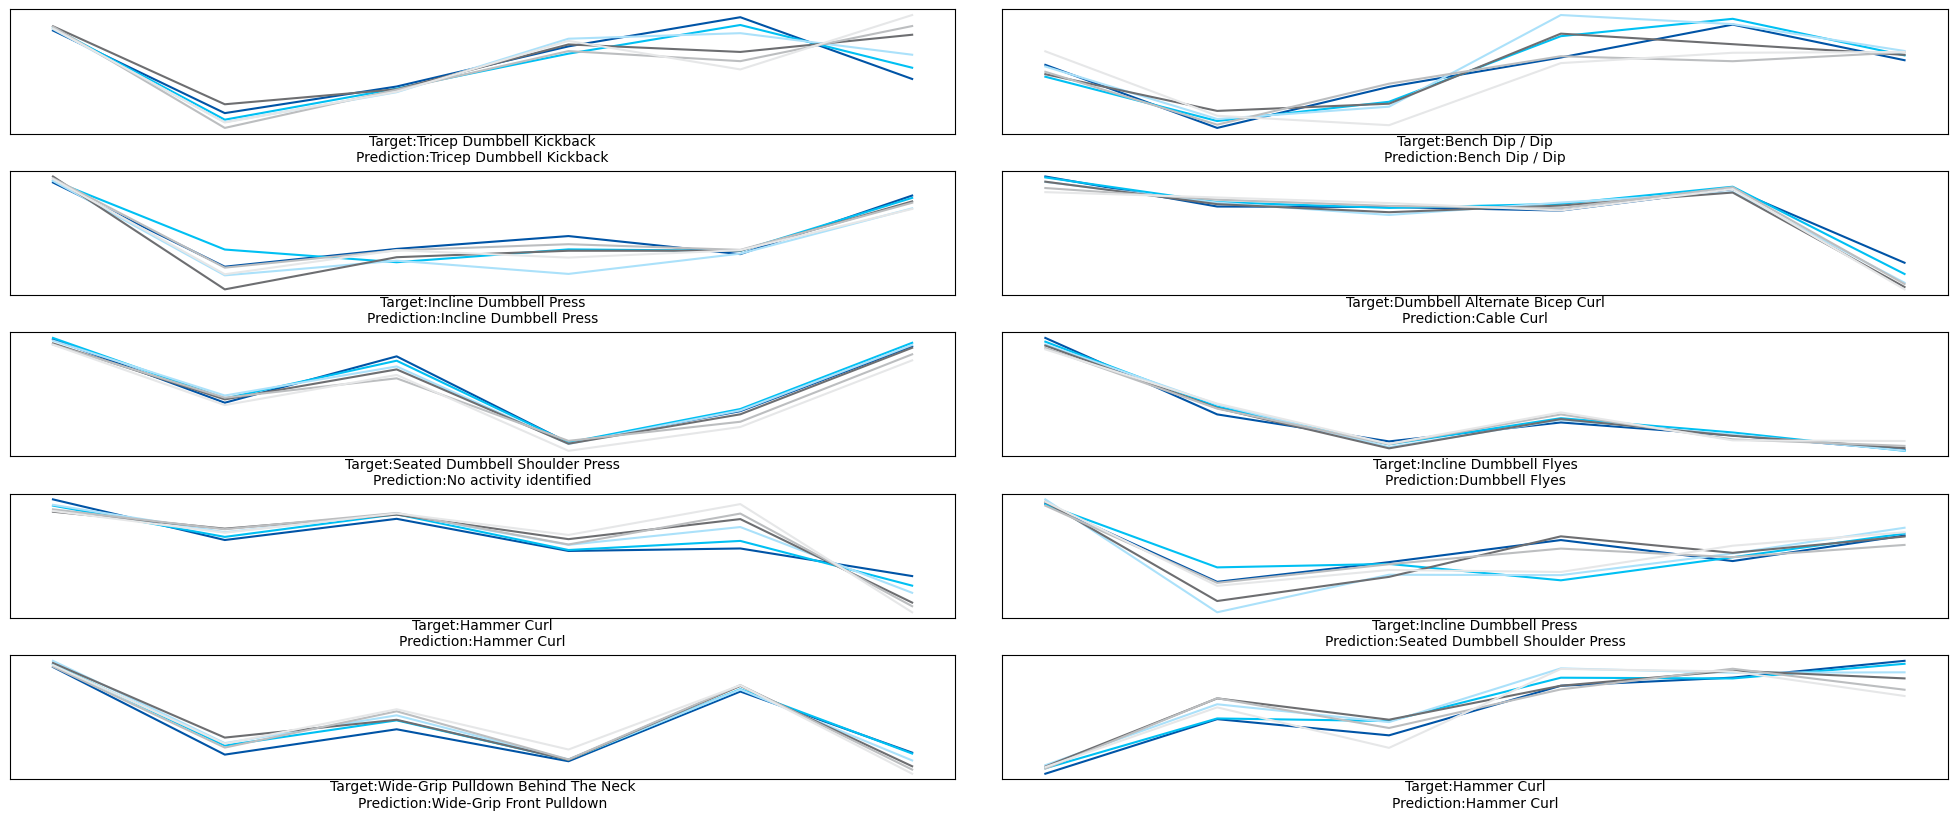

In [17]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_test)

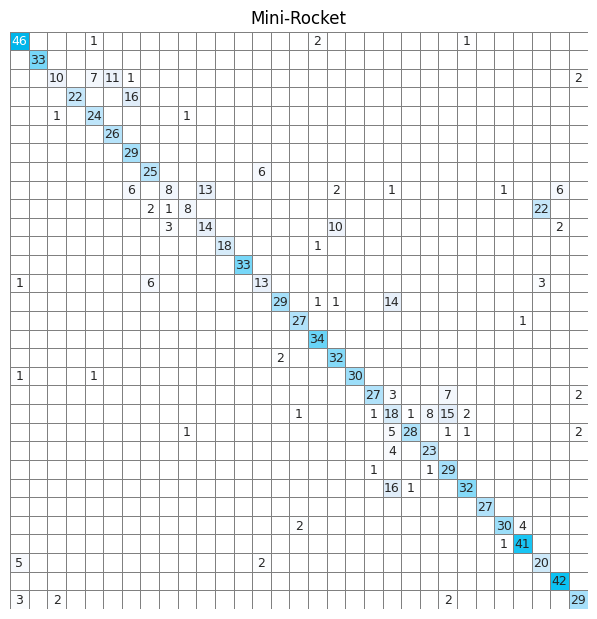

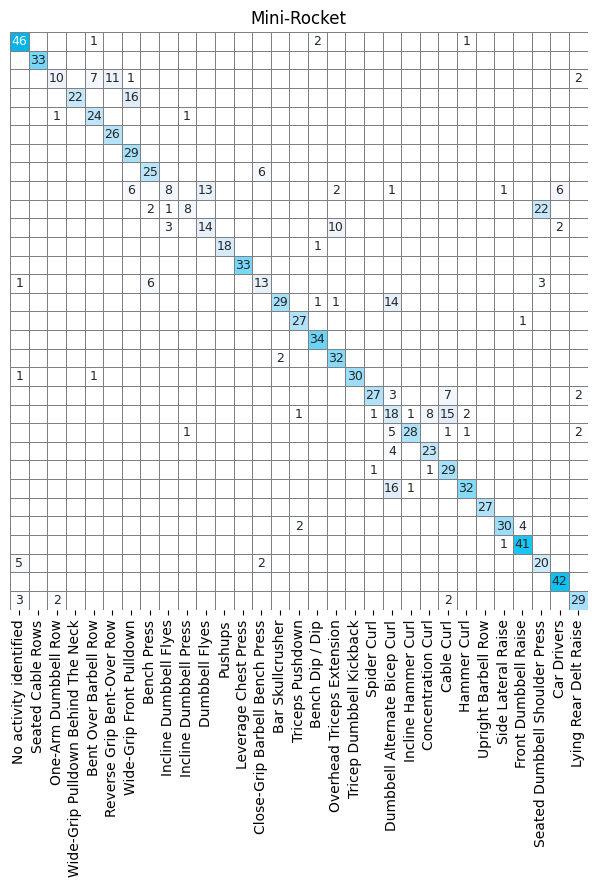

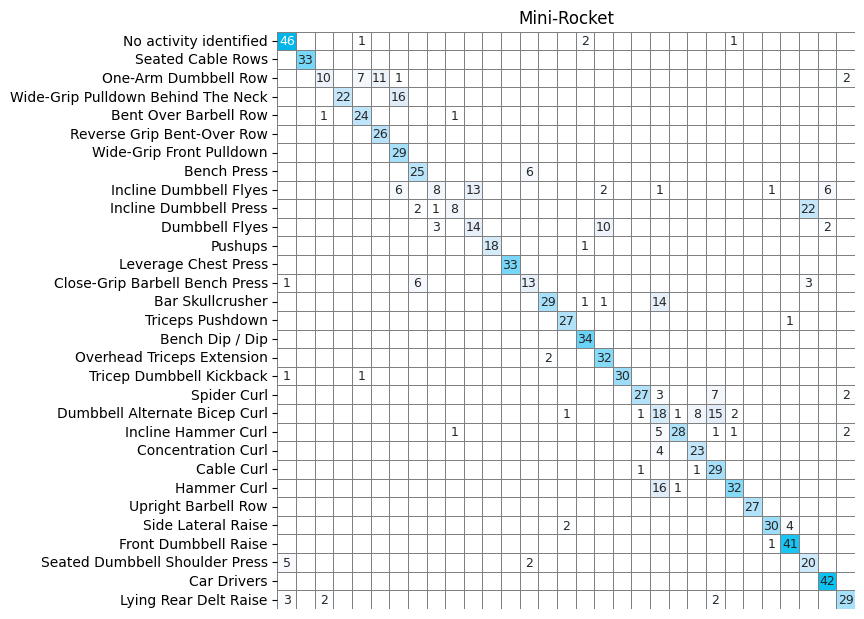

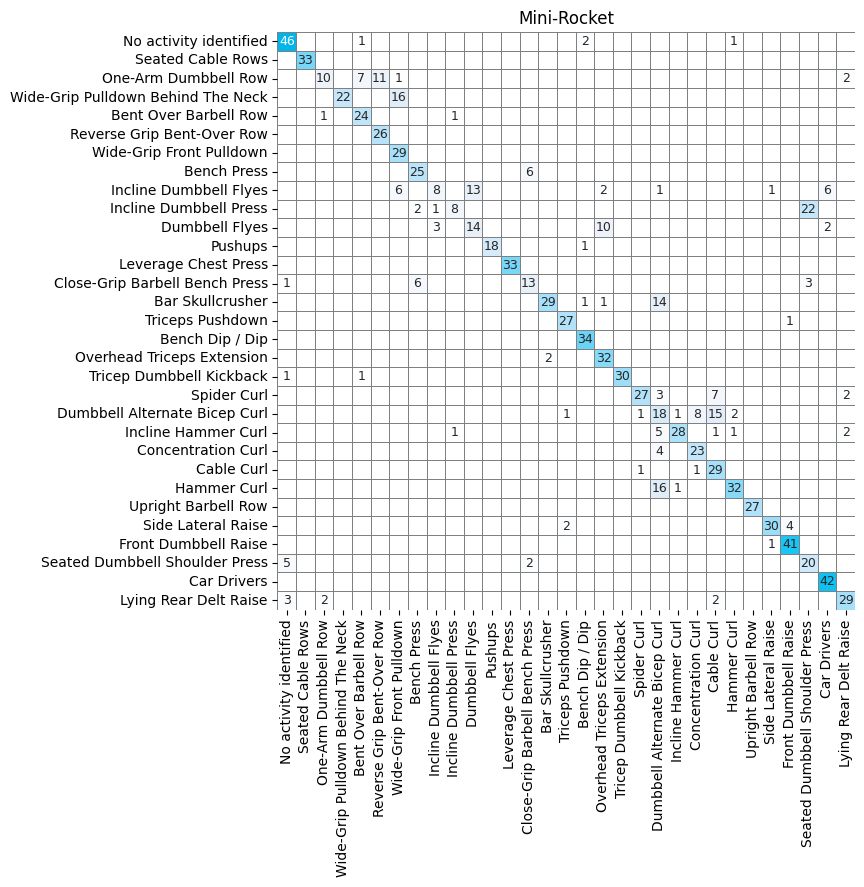

In [18]:
cm = confusion_matrix(y_test, predictions_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm, x_ticks = False, y_ticks = False, save = True, title = "Mini-Rocket")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = False, save = True, title = "Mini-Rocket")
plot_confusion_matrix(cm, x_ticks = False, y_ticks = True, save = True, title = "Mini-Rocket")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = True, save = True, title = "Mini-Rocket")

This has a slightly better performance than Rocket on this MyoGym data, but approx 50 times faster compute time. It is the best performing benchmark method tested.

### **References**

[1] Dempster A, Schmidt DF, Webb GI (2020) MiniRocket: A Very Fast (Almost) Deterministic Transform for Time Series Classification [arXiv:2012.08791](https://arxiv.org/abs/2012.08791)